##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 6:** Architektury sieci splotowych - ResNet

**Przykład (3):** ResNet


W ramach tego notatnika przedstawiamy przykładowe kody umożliwiające praktyczne zapoznanie się elementami architektur bazujących na ResNet.

Szczegóły dotyczące modelu można znaleźć w:

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun (2015) Deep Residual Learning for Image Recognition https://arxiv.org/abs/1512.03385


Wskażmy pakiety, z jakich będziemy korzystać:


In [ ]:
import numpy as np
import datetime, os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme()
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

# You can try to change your Google Colab environment to GPU
print(tf.__version__)

# You can always check which packages are installed using:
# !pip list

2.7.0


In [ ]:
# Check if you have GPU resources (Runtime / Change runtime type -> GPU)
!nvidia-smi

Fri Nov 19 11:23:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check devices using TF
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Przedstawmy budowę podstawowej wersji bloku ResNet:

In [ ]:
def residual_block(img_input, filters, rescale=False, b_name='1'):

    ch_axis = -1 # defualt (channel_last)
    stride = 1
    w_init = 'he_uniform'
    n = '_'+b_name

    # Store skip connection
    skip_connection = img_input

    # Optionally add skip connection with Conv2D(1x1) and BN
    if rescale == True:
      stride = 2
      skip_connection = tf.keras.layers.Conv2D(filters, (1,1),
                                               strides=(stride,stride),
                                               kernel_initializer=w_init,
                                               name='skip_conv'+n)(skip_connection)
      skip_connection = tf.keras.layers.BatchNormalization(axis=ch_axis,
                                                           name='skip_bn'+n)(skip_connection)

    # First set of layers
    x = tf.keras.layers.Conv2D(filters, (3,3), padding ='same',
                               strides=(stride,stride),
                               kernel_initializer=w_init,
                               name='conv_1'+n)(img_input)
    x = tf.keras.layers.BatchNormalization(axis=ch_axis, name='bn_1'+n)(x)
    x = tf.keras.layers.Activation('relu', name='act_1'+n)(x)
    # Second set of layers - default stride!!!
    x = tf.keras.layers.Conv2D(filters, (3,3), padding = 'same',
                               kernel_initializer=w_init, name='conv_2'+n)(x)
    x = tf.keras.layers.BatchNormalization(axis=ch_axis, name='bn_2'+n)(x)

    # Add connections
    x = tf.keras.layers.Add()([x, skip_connection])
    output = tf.keras.layers.Activation('relu', name='act_block'+n)(x)

    model = tf.keras.Model(img_input, output, name='residual_block'+n)

    return model

Zastosujmy blok i zapoznajmy się w wydrukiem informacji o poszczególnych warstwach.

In [ ]:
data = np.ones((1,28,28,64))
input_shape = (data.shape[1],data.shape[2],data.shape[3])
img_input = tf.keras.layers.Input(shape=input_shape, name='b_input')
model_no_reduce = residual_block(img_input, 64)
print(model_no_reduce(data).shape)

model_no_reduce.summary()

(1, 28, 28, 64)
Model: "residual_block_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 b_input (InputLayer)           [(None, 28, 28, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_1_1 (Conv2D)              (None, 28, 28, 64)   36928       ['b_input[0][0]']                
                                                                                                  
 bn_1_1 (BatchNormalization)    (None, 28, 28, 64)   256         ['conv_1_1[0][0]']               
                                                                                                  
 act_1_1 (Activation)           (None, 28, 28, 64)   0           ['

Zastosujmy blok w wersji ze skalowaniem danych w połaczeniu recydualnym i zapoznajmy się w wydrukiem informacji o poszczególnych warstwach.

In [ ]:
data = np.ones((1,28,28,3))
input_shape = (data.shape[1],data.shape[2],data.shape[3])
img_input = tf.keras.layers.Input(shape=input_shape, name='b_input')

#Input depth 256 is not equal to output depth 64, so we need to rescale
model_with_reduce = residual_block(img_input=img_input, filters=64, rescale=True)
print(model_with_reduce(data).shape)

model_with_reduce.summary()

(1, 14, 14, 64)
Model: "residual_block_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 b_input (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1_1 (Conv2D)              (None, 14, 14, 64)   1792        ['b_input[0][0]']                
                                                                                                  
 bn_1_1 (BatchNormalization)    (None, 14, 14, 64)   256         ['conv_1_1[0][0]']               
                                                                                                  
 act_1_1 (Activation)           (None, 14, 14, 64)   0           ['bn_1_1[0][0]']                 
                                                                   

Spróbujmy zbudować model złożony dwóch bloków recydualnych.

In [ ]:
def get_Model(input_shape, no_of_classes):

    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #print(x.shape[1:])

    x_in_1 = tf.keras.Input(shape=x.shape[1:])
    base_model_1 = residual_block(x_in_1, 64, rescale=False, b_name='1')
    x = base_model_1(x, training=True)

    x_in_2 = tf.keras.Input(shape=x.shape[1:])
    base_model_2 = residual_block(x_in_2, 256, rescale=True, b_name='2')
    x = base_model_2(x, training=True)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x =  tf.keras.layers.Dense(256)(x)
    outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax' )(x)

    model = tf.keras.Model(inputs, outputs, name='simple_res_net')

    return model

Ponownie będziemy chcieli zastosowań nowy model dla danych CIFAR-10. Przykład wykorzystamy jedynie do demonstracji użycia modelu - nie jest on optymalizaowany ze względu na wynik jakości rozpatrywanego problemu klasyfikcji danych. Również kody źródłowe są tak skonstruowane, aby przedstawić kolejne kroki działań i nie są optymalizowane.

Zachęcem do eksperymentowania na innych bazach danych takich jak CIFAR-100, ImageNet, itp.

Zróbmy eksperyment ponownie z danymi CIFAR-10.

170508288/170498071 [==============================] - 3s 0us/step
True original label : 6 frog


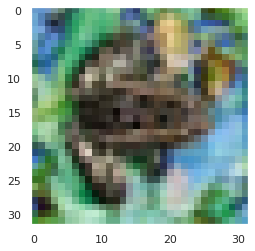

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
'airplane','automobile','bird', 'cat', 'deer' ,
'dog', 'frog', 'horse', 'ship', 'truck']

# Data properties
image_width = 32;
image_height = 32;
image_components = 3

# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow(x_train[example])
print("True original label :", class_id, class_names[class_id])


Zdefiniujmy ważne parametry i źródła danych.

In [ ]:
no_of_classes = 10

# You can try to standsardize images (using mean and std. dev.)
standardize = True

if standardize:
    # per channel:
    for i in range(3):
        x_train_mean = np.mean(x_train[:,:,:,i])
        x_train_std = np.std(x_train[:,:,:,i])
        x_train[:,:,:,i] = (x_train[:,:,:,i] -x_train_mean) / x_train_std
        x_test[:,:,:,i] = (x_test[:,:,:,i] -x_train_mean) /x_train_std

    # per dataset:
#     x_train_mean = np.mean(x_train)
#     x_train_std = np.std(x_train)

#     x_train = (x_train - x_train_mean)/x_train_std
#     x_test = (x_test - x_train_mean)/x_train_std

else:
    x_train = x_train / 255.0
    x_test = x_test / 255.0

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))



Zdefiniujmy źródło danych z potokiem przetwarzania.


Pamiętajmy również, że im większy rozmiar porcji danych (rozmiar danych i batch) tym więcej potrzebujemy pamięci.

In [ ]:
# Preprocessing
buffer_size = 1024
batch_size = 128


train_ds = (train_ds
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))

valid_ds = (valid_ds
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))

Utwórzmy instancję prostego modelu i zapoznajmy się z wydrukiem warstw.

In [ ]:
# Model to train
input_shape = (image_height, image_width, image_components)
model_to_train = get_Model(input_shape, no_of_classes)

model_to_train.summary()

Model: "simple_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 residual_block_1 (Functiona  (None, 32, 32, 64)       74368     
 l)                                                              
                                                                 
 residual_block_2 (Functiona  (None, 16, 16, 256)   

Przygotujmy również procedurę dynamicznej zmian współczynika szybkości uczenia (uwaga: poniższa procedura praktycznie nie wprowadzi żadnych zmian przy ustawieniu początkowej wartości współczynnika szybkości uczenia  na lr=0.001, co może być ważne dla "adaptacyjnych" algorytmów optymalizacyjnych, w których zgodnie z definicją współczynnik szybkości uczenia podlega adaptacyjnej zmianie.).

In [ ]:
# Remember, if you use the "Adam" optimizer or similar then learning rate can
# automatically change between epochs: see the definition of the Adam opt.

def scheduler(epoch, lr):

  if epoch < 40:
    eta = lr
  else:
    eta = lr * tf.math.exp(-0.01)

  if eta < 0.001:
    eta = 0.001

  print("Learning rate is: ", eta)
  return eta



Przygotujmy ustawienia procedury uczenia.

In [ ]:
def train_model(model, callbacks, opt, epochs=10, batch_size=32):
  """
  Train model - use some global variable (you can modify the definition
                to make this function more univeral)

  """

  model.compile(
    # Choose the optimizer
    optimizer=opt,
    # we use sparse version of the loss -> we do not need to use to_categorical()
    loss='sparse_categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
  )

  model.fit(train_ds,
            epochs=epochs,
            batch_size=batch_size,
            # Use test data to perform validation
            validation_data=valid_ds,
            # Assign reference to the TB callback function
            callbacks=callbacks)

Zdefiniujmy stosowne hiperparametry, wybierzmy algorytm optymalizacji, a następnie przeprowadźmy trening. Z góry zachęcam do przeprowadzenia wielu eksperymentów z różnymi ustawieniami modelu, algorytmu optymalizacyjnego oraz z zastosowaniem augmentacji danych (której dla prostoty przykładu nie stosujemy).

Warto pobrać kopię notatnika i uruchomić go na innym (np. własnym) komputerze.

In [ ]:
# Use "logs" folder to for TB data
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# All callback functions
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [lr_scheduler, tensorboard_callback]

# Redefine hiperparameters - e.g. use more epoch in the experiments
# epochs = 200
epochs = 20
learning_rate = 0.01

# You can try different optimalization algorithms
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd, epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Learning rate is:  0.009999999776482582
Epoch 1/20
390/390 [==============================] - 48s 113ms/step - loss: 1.8286 - accuracy: 0.3300 - val_loss: 1.7008 - val_accuracy: 0.3886 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 2/20
390/390 [==============================] - 44s 114ms/step - loss: 1.6288 - accuracy: 0.4110 - val_loss: 1.5731 - val_accuracy: 0.4428 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 3/20
390/390 [==============================] - 44s 114ms/step - loss: 1.5359 - accuracy: 0.4505 - val_loss: 1.5036 - val_accuracy: 0.4629 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 4/20
390/390 [==============================] - 44s 114ms/step - loss: 1.4712 - accuracy: 0.4770 - val_loss: 1.4461 - val_accuracy: 0.4813 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 5/20
390/390 [==============================] - 45s 115ms/step - loss: 1.4165 - accuracy: 0.4960 - val_loss: 1.4111 - val_accuracy: 0.4991 - lr: 0.0100
Learning r

Rozwińmy następnie nasz model zwiększając liczbę bloków rezydualnych do 8 (na wzór ResNet18: 1 warstwa splotowa na wejściu, 16 warstw spolotowych w 8 blokach [nie licząc warstw w połączeniach rezydualnych], 1 warstwa gęsta na końcu [nie licząc ostatniej warstwy gęstej z sotmax]).

In [ ]:
def get_ResNet18(input_shape, no_of_classes):

    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #print(x.shape[1:])

    x_in_1 = tf.keras.Input(shape=x.shape[1:])
    base_model_1 = residual_block(x_in_1, 64, rescale=False, b_name='1')
    x = base_model_1(x, training=True)

    x_in_2 = tf.keras.Input(shape=x.shape[1:])
    base_model_2 = residual_block(x_in_2, 64, rescale=False, b_name='2')
    x = base_model_2(x, training=True)

    x_in_3 = tf.keras.Input(shape=x.shape[1:])
    base_model_3 = residual_block(x_in_3, 128, rescale=True, b_name='3')
    x = base_model_3(x, training=True)

    x_in_4 = tf.keras.Input(shape=x.shape[1:])
    base_model_4 = residual_block(x_in_4, 128, rescale=False, b_name='4')
    x = base_model_4(x, training=True)

    x_in_5 = tf.keras.Input(shape=x.shape[1:])
    base_model_5 = residual_block(x_in_5, 256, rescale=True, b_name='5')
    x = base_model_5(x, training=True)

    x_in_6 = tf.keras.Input(shape=x.shape[1:])
    base_model_6 = residual_block(x_in_6, 256, rescale=False, b_name='6')
    x = base_model_6(x, training=True)

    x_in_7 = tf.keras.Input(shape=x.shape[1:])
    base_model_7 = residual_block(x_in_7, 512, rescale=True, b_name='7')
    x = base_model_7(x, training=True)

    x_in_8 = tf.keras.Input(shape=x.shape[1:])
    base_model_8 = residual_block(x_in_8, 512, rescale=False, b_name='8')
    x = base_model_8(x, training=True)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x =  tf.keras.layers.Dense(1024)(x)
    outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax' )(x)

    model = tf.keras.Model(inputs, outputs, name='res_net_18_like')

    return model

Utwórzmy instancję prostego modelu i zapoznajmy się z wydrukiem warstw.

In [ ]:
input_shape = (image_height, image_width, image_components)
model_to_train = get_ResNet18(input_shape, no_of_classes)

model_to_train.summary()

Model: "res_net_18_like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        9472      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 residual_block_1 (Functiona  (None, 32, 32, 64)       74368     
 l)                                                              
                                                                 
 residual_block_2 (Functiona  (None, 32, 32, 64)   

Przeprowadźmy trening (warto rozwinąć trening o więcej epok i np. augmentację dnych - zachęcam do eksperymentowania).

In [ ]:
# Use "logs" folder to for TB data
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# All callback functions
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [lr_scheduler, tensorboard_callback]

# Redefine hiperparameters - e.g. use more epoch in the experiments
# epochs = 200
epochs = 20
learning_rate = 0.01

# You can try different optimalization algorithms
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd, epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Learning rate is:  0.009999999776482582
Epoch 1/20
390/390 [==============================] - 106s 262ms/step - loss: 1.7644 - accuracy: 0.3665 - val_loss: 1.5518 - val_accuracy: 0.4421 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 2/20
390/390 [==============================] - 102s 261ms/step - loss: 1.4018 - accuracy: 0.5005 - val_loss: 1.3798 - val_accuracy: 0.5069 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 3/20
390/390 [==============================] - 102s 261ms/step - loss: 1.1820 - accuracy: 0.5815 - val_loss: 1.3491 - val_accuracy: 0.5272 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 4/20
390/390 [==============================] - 102s 261ms/step - loss: 0.9800 - accuracy: 0.6551 - val_loss: 1.3968 - val_accuracy: 0.5310 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 5/20
390/390 [==============================] - 102s 261ms/step - loss: 0.7905 - accuracy: 0.7221 - val_loss: 1.5585 - val_accuracy: 0.5291 - lr: 0.0100
Learn

Uzyskane wyniki mogę nie być satysfakcjonujące dla danych walidacyjnych/testowych. Wprowadźmy dodatkowo augmentację danych demonstrując jak tworzenie modelu można podzielić na funkcjonalne części i z nich zestawić gotowy, nowy model.

In [ ]:
img_height_dst = image_height * 2
img_width_dst = image_width * 2
img_depth_dst = 3

input_shape_dst = (img_height_dst, img_width_dst, img_depth_dst)

resize_layer = tf.keras.Sequential([
  tf.keras.layers.Resizing(input_shape_dst[0], input_shape_dst[1]),
])

augmentation_layer = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=input_shape_dst),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1),width_factor=(-0.1, 0.1),fill_mode="constant", fill_value=0.0),
  ]
)

normalization_layer = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
])

Zdefiniujmy funkcję generacji modelu złożonego z innego modelu i zbioru warstw.

In [ ]:
def get_Model_Augm(input_shape, no_of_classes=10):
    # Building Model
    prep_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        resize_layer,
        augmentation_layer,
        # normalization_layer,
        ])

    inputs = tf.keras.Input(shape=input_shape)

    x = prep_model(inputs)

    # inputs = prep_model.output
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #print(x.shape[1:])

    x_in_1 = tf.keras.Input(shape=x.shape[1:])
    base_model_1 = residual_block(x_in_1, 64, rescale=False, b_name='1')
    x = base_model_1(x, training=True)

    x_in_2 = tf.keras.Input(shape=x.shape[1:])
    base_model_2 = residual_block(x_in_2, 64, rescale=False, b_name='2')
    x = base_model_2(x, training=True)

    x_in_3 = tf.keras.Input(shape=x.shape[1:])
    base_model_3 = residual_block(x_in_3, 128, rescale=True, b_name='3')
    x = base_model_3(x, training=True)

    x_in_4 = tf.keras.Input(shape=x.shape[1:])
    base_model_4 = residual_block(x_in_4, 128, rescale=False, b_name='4')
    x = base_model_4(x, training=True)

    x_in_5 = tf.keras.Input(shape=x.shape[1:])
    base_model_5 = residual_block(x_in_5, 256, rescale=True, b_name='5')
    x = base_model_5(x, training=True)

    x_in_6 = tf.keras.Input(shape=x.shape[1:])
    base_model_6 = residual_block(x_in_6, 256, rescale=False, b_name='6')
    x = base_model_6(x, training=True)

    x_in_7 = tf.keras.Input(shape=x.shape[1:])
    base_model_7 = residual_block(x_in_7, 512, rescale=True, b_name='7')
    x = base_model_7(x, training=True)

    x_in_8 = tf.keras.Input(shape=x.shape[1:])
    base_model_8 = residual_block(x_in_8, 512, rescale=False, b_name='8')
    x = base_model_8(x, training=True)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x =  tf.keras.layers.Dense(1024)(x)
    outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax' )(x)

    model = tf.keras.Model(inputs, outputs, name='res_net_augm')

    return model

Utwórzmy instancję prostego modelu i zapoznajmy się z wydrukiem warstw.

In [ ]:
input_shape = (image_height, image_width, image_components)
model_to_train = get_Model_Augm(input_shape, no_of_classes)

model_to_train.summary()

Model: "res_net_augm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        9472      
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 residual_block_1 (Functiona  (None, 64, 64, 64)       74368     
 l)                                                   

Przeprowadźmy trening nowego modelu zawierającego operacje augmentacji.

In [ ]:
# Use "logs" folder to for TB data
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# All callback functions
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [lr_scheduler, tensorboard_callback]

# Redefine hiperparameters - e.g. use more epoch in the experiments
# epochs = 200
epochs = 20
learning_rate = 0.01

# You can try different optimalization algorithms
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd, epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Learning rate is:  0.009999999776482582
Epoch 1/20
390/390 [==============================] - 330s 830ms/step - loss: 1.8278 - accuracy: 0.3378 - val_loss: 1.5806 - val_accuracy: 0.4312 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 2/20
390/390 [==============================] - 322s 826ms/step - loss: 1.5657 - accuracy: 0.4361 - val_loss: 1.4015 - val_accuracy: 0.4948 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 3/20
390/390 [==============================] - 323s 829ms/step - loss: 1.4644 - accuracy: 0.4742 - val_loss: 1.3118 - val_accuracy: 0.5378 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 4/20
390/390 [==============================] - 323s 828ms/step - loss: 1.3903 - accuracy: 0.5008 - val_loss: 1.2446 - val_accuracy: 0.5557 - lr: 0.0100
Learning rate is:  0.009999999776482582
Epoch 5/20
390/390 [==============================] - 321s 823ms/step - loss: 1.3348 - accuracy: 0.5235 - val_loss: 1.2122 - val_accuracy: 0.5640 - lr: 0.0100
Learn

Na koniec zauważmy, że w TF są dostępne predefiniowane modele klasy ResNet. Poniżej pokazujemy przykładowych wydruk warstw dla dostępnego modelu ResNet50 z wskazaniem rozmiaru danych i liczby klas jak dla CIFAR-10.

In [ ]:
model_to_train = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=None,
    input_shape=(image_height,image_width,image_components),
    pooling=None, classes=no_of_classes,
    classifier_activation='softmax'
)

model_to_train.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_23[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

Proszę samodzielnie spróbować zastosować dostępny model ResNet50, budując na jego podstawie model obejmujący augmentację danych, większą liczbę epok i inne techniki tak, aby uzyskać jak najlepszy wynik klasyfikacji danych dla zbioru testowego.

Zachęcam do eksperymentowania. Warto np. pobrać bazę ImageNet (https://image-net.org/download.php) i spróbować przeprowadzić trening modelu (Uwaga! Zbiór danych jest obszerny i proces uczenia może trwać bardzo długo - w zależności od dostępnej infrastruktury obliczeniowej). Można również poeksperymentować z wersjami ImageNet o pomniejszonych rozmiarach obrazów.

Warto również dokonać eksperymentów z uwzględnieniem augmentacji danych.

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>